# OLG 移行過程の計算

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numba import njit
from typing import Tuple, Callable, Optional
import numpy.typing as npt
from dataclasses import dataclass
import time

# Set plotting style
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 12

## utils.py

- maliar_grid()
- inverse_interp_aprime_point_numba()
- inverse_interp_aprime_point()

In [2]:
@njit
def maliar_grid(a_min: float, a_max: float, N: int, theta: float) -> np.ndarray:
    """
    Maliarグリッド関数
    低資産域により多くのグリッドポイントを配置する非線形グリッド

    Parameters
    ----------
    a_min : float
        グリッドの最小値
    a_max : float
        グリッドの最大値
    N : int
        グリッドポイント数
    theta : float
        グリッドの曲率パラメータ（1.0で等間隔、>1.0で低資産域により密）

    Returns
    -------
    np.ndarray
        Maliarグリッド配列
    """
    a_grid = np.empty(N)
    for i in range(1, N + 1):
        a_grid[i - 1] = a_min + (a_max - a_min) * ((i - 1) / (N - 1)) ** theta
    return a_grid


@njit
def inverse_interp_aprime_point_numba(
    a_grid: np.ndarray, aprime_value: float
) -> Tuple[float, int, int, float, float]:
    """
    1つの aprime_value を、グローバルな a_grid 上で線形補間により逆補間する。

    Parameters
    ----------
    a_grid : np.ndarray
        資産グリッド（単調増加）
    aprime_value : float
        補間したい次期資産の値

    Returns
    -------
    Tuple[float, int, int, float, float]
        - aprime_interp: 線形補間により a_grid 上で再構成された aprime_value
        - idx_left: 左のインデックス
        - idx_right: 右のインデックス
        - weight_left: 左の重み
        - weight_right: 右の重み

    Notes
    -----
    weight_left + weight_right = 1.0
    aprime_interp = weight_left * a_grid[idx_left] + weight_right * a_grid[idx_right]
    """
    if aprime_value <= a_grid[0]:
        return a_grid[0], 0, 1, 1.0, 0.0
    elif aprime_value >= a_grid[-1]:
        last_idx = len(a_grid) - 1
        return a_grid[-1], last_idx - 1, last_idx, 0.0, 1.0
    else:
        # バイナリサーチの代わりに線形サーチ（numbaでより効率的）
        idx = 0
        for i in range(len(a_grid) - 1):
            if a_grid[i] <= aprime_value < a_grid[i + 1]:
                idx = i
                break

        a_left = a_grid[idx]
        a_right = a_grid[idx + 1]
        weight_R = (aprime_value - a_left) / (a_right - a_left)
        weight_L = 1.0 - weight_R
        aprime_interp = weight_L * a_left + weight_R * a_right
        return aprime_interp, idx, idx + 1, weight_L, weight_R


def inverse_interp_aprime_point(
    hp: "Setting", aprime_value: float
) -> Tuple[float, int, int, float, float]:
    """
    1つの aprime_value を、グローバルな a_grid 上で線形補間により逆補間する。

    Parameters
    ----------
    hp : Setting
        OLGモデルの設定オブジェクト
    aprime_value : float
        補間したい次期資産の値

    Returns
    -------
    Tuple[float, int, int, float, float]
        inverse_interp_aprime_point_numba の戻り値と同じ

    See Also
    --------
    inverse_interp_aprime_point_numba : numba最適化版の実装
    """
    return inverse_interp_aprime_point_numba(hp.a_grid, aprime_value)

## setting.py

In [3]:
class Setting:
    """
    OLGモデルの設定クラス
    """

    # 基本パラメータ（整数型）
    NJ: int  # モデルの期間（世代数）20歳から80歳まで
    Njw: int  # 働く期間 20歳から64歳まで働く
    Nl: int  # 生産性のグリッドの数 {high,low}の2種類
    Na: int  # 今期の資産グリッドの数
    Naprime: int  # 来季の資産グリッドの数
    maxiter: int  # 最大繰り返し回数

    # 基本パラメータ（浮動小数点型）
    l_dif: float  # 生産性の違い
    a_max: float  # 資本グリッドの最大値
    a_min: float  # 資本グリッドの最小値
    alpha: float  # 資本分配率
    beta: float  # 割引因子
    gamma: float  # 相対的リスク回避度（異時点間の代替弾力性の逆数）
    delta: float  # 固定資本減耗率
    psi: float  # 年金の平均所得代替率
    K0: float  # 初期資産
    tol: float  # 収束判定の閾値
    lambdaR: float  # 資本更新調整係数

    # グリッド配列
    h_grid: npt.NDArray[np.floating]  # 年齢グリッド
    l_grid: npt.NDArray[np.floating]  # 生産性グリッド
    a_grid: npt.NDArray[np.floating]  # 今期資産グリッド
    aprime_grid: npt.NDArray[np.floating]  # 次期資産グリッド
    P: npt.NDArray[np.floating]  # 生産性遷移確率行列

    # 効用関数
    utility: Callable[[float], float]  # CRRA型効用関数
    mutility: Callable[[float], float]  # 限界効用関数

    def __init__(
        self,
        NJ: int = 61,  # モデルの期間,20歳から80歳まで生きる
        Njw: int = 45,  # 働く期間,20歳から64歳まで働く
        # Njr: int = 20,      # 勤労期の初期,20歳から働く 使ってない
        Nl: int = 2,  # 生産性のグリッドの数, {high,low}の2種類
        l_dif: float = 0.3,  # 生産性の違い（6.3設定に合わせて0.3→0.2）
        Na: int = 201,  # 今期の資産グリッドの数
        a_max: float = 25,  # 資本グリッドの最大値
        a_min: float = 0,  # 資本グリッドの最小値
        Naprime: int = 8001,  # 来季の資産グリッドの数
        alpha: float = 0.4,  # 資本分配率
        beta: float = 0.98,  # 割引因子
        gamma: float = 1,  # 相対的リスク回避度(異時点間の代替弾力性の逆数)
        delta: float = 0.08,  # 固定資本減耗率
        psi: float = 0.5,  # 年金の平均所得代替率
        K0: float = 6.0,  # 初期資産
        tol: float = 1e-3,  # 収束判定の閾値
        maxiter: int = 2000,  # 最大繰り返し回数
        lambdaR: float = 0.2,  # 資本更新調整係数
        # jw: int = 20,      # 勤労期の初期 j work
        # jr: int = 45,      # 引退期の初期 j retire
    ) -> None:
        # パラメータを設定する
        self.NJ = NJ
        self.Njw = Njw
        # self.Njr     = Njr
        self.Nl = Nl
        self.l_dif = l_dif
        self.Na = Na
        self.Naprime = Naprime
        self.a_max = a_max
        self.a_min = a_min
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.delta = delta
        self.psi = psi
        self.K0 = K0
        self.tol = tol
        self.maxiter = maxiter
        self.lambdaR = lambdaR

        # グリッドの設定
        h_grid = np.linspace(1, NJ, NJ)  # 年齢のグリッド
        l_grid = np.zeros(Nl)
        l_grid[0] = 1.0 - l_dif
        l_grid[1] = 1.0 + l_dif
        a_grid = maliar_grid(
            a_min, a_max, Na, 1.20
        )  # 今期資産グリッド（Maliarグリッド）
        aprime_grid = maliar_grid(
            a_min, a_max, Naprime, 1.20
        )  # 次期資産グリッド（Maliarグリッド）

        self.h_grid = h_grid
        self.l_grid = l_grid
        self.a_grid = a_grid
        self.aprime_grid = aprime_grid

        # 生産性の遷移確率行列Pの用意
        P_HH = 0.8
        P_LL = 0.8

        P = np.array([[P_HH, 1 - P_HH], [1 - P_LL, P_LL]])
        self.P = P

        # CRRA型効用関数と限界効用を定義する
        if self.gamma == 1:
            # 対数効用の場合
            self.utility: Callable[[float], float] = np.log
            self.mutility: Callable[[float], float] = njit(lambda x: 1 / x)
        else:
            # CRRA効用の場合（self.gammaを直接参照）
            self.utility = njit(lambda x: x ** (1 - self.gamma) / (1 - self.gamma))
            self.mutility = njit(lambda x: x ** (-self.gamma))

## transition_setting.py

In [ ]:
class TransitionSetting:
    """
    移行過程計算用の設定クラス

    移行過程に必要な固有パラメータと時間軸での政策パスを管理します。
    """

    # 移行過程固有パラメータ（整数型）
    NT: int  # 移行期間
    TT: int  # 政策変更の収束期間
    maxiterTR: int  # 移行過程用の最大繰り返し回数

    # 移行過程固有パラメータ（浮動小数点型）
    psi_ini: float  # 初期定常状態の所得代替率
    psi_fin: float  # 最終定常状態の所得代替率
    errKTol: float  # 移行過程用の市場クリア誤差許容度
    adjK_TR: float  # 移行過程用の資本更新調整係数

    # 移行過程用の時間軸配列
    rhoT: npt.NDArray[np.floating]  # 時間ごとの所得代替率パス (NT,)
    tauT: npt.NDArray[np.floating]  # 時間ごとの税率パス (NT,)

    def __init__(
        self,
        # 移行過程固有パラメータ
        NT: int = 100,  # 移行期間
        TT: int = 25,  # 政策変更の収束期間
        psi_ini: float = 0.5,  # 初期定常状態の所得代替率
        psi_fin: float = 0.25,  # 最終定常状態の所得代替率
        errKTol: float = 1e-4,  # 移行過程用の市場クリア誤差許容度
        maxiterTR: int = 300,  # 移行過程用の最大繰り返し回数
        adjK_TR: float = 0.05,  # 移行過程用の資本更新調整係数
        # 税率計算用パラメータ（人口分布計算に必要）
        NJ: int = 61,  # 年齢数（税率計算用）
        Njw: int = 45,  # 労働期間（税率計算用）
    ) -> None:
        # 移行過程固有パラメータの設定
        self.NT = NT
        self.TT = TT
        self.psi_ini = psi_ini
        self.psi_fin = psi_fin
        self.errKTol = errKTol
        self.maxiterTR = maxiterTR
        self.adjK_TR = adjK_TR

        # 税率計算用パラメータ
        self.NJ = NJ
        self.Njw = Njw

        # 時間軸での所得代替率パスを設定
        self.rhoT = self._create_replacement_rate_path()

        # 時間軸での税率パスを設定
        self.tauT = self._create_tax_rate_path()

    def _create_replacement_rate_path(self) -> npt.NDArray[np.floating]:
        """
        時間軸での所得代替率パスを作成

        1期目のpsi_iniからTT期目のpsi_finまで線形に減少し、
        以降は最終期まで psi_fin で一定

        Returns
        -------
        npt.NDArray[np.floating]
            所得代替率パス (NT,)
        """
        rhoT = np.zeros(self.NT)

        # 1期目からTT期目まで線形に変化
        for t in range(self.TT):
            rhoT[t] = self.psi_ini + ((self.psi_fin - self.psi_ini) / (self.TT - 1)) * t

        # TT期目以降は psi_fin で一定
        rhoT[self.TT :] = self.psi_fin

        return rhoT

    def _create_tax_rate_path(self) -> npt.NDArray[np.floating]:
        """
        時間軸での税率パスを作成

        各期の所得代替率に基づいて税率を計算:
        τ_t = ψ_t × (退職者人口) / (労働者人口)

        Returns
        -------
        npt.NDArray[np.floating]
            税率パス (NT,)
        """
        tauT = np.zeros(self.NT)

        # 年齢別人口分布（均等分布を仮定）
        h_dist = np.ones(self.NJ) / self.NJ

        # 退職者と労働者の人口比率
        retiree_ratio = np.sum(h_dist[self.Njw :])
        worker_ratio = np.sum(h_dist[: self.Njw])

        for t in range(self.NT):
            tauT[t] = self.rhoT[t] * retiree_ratio / worker_ratio

        return tauT

    def create_ss_settings(self, **kwargs) -> Tuple[Setting, Setting]:
        """
        初期・最終定常状態用のSettingインスタンスを作成

        psi以外のパラメータは両方で同じ値を使用します。

        Parameters
        ----------
        **kwargs
            Settingクラスのパラメータを上書きする場合に指定

        Returns
        -------
        Tuple[Setting, Setting]
            (初期定常状態用Setting, 最終定常状態用Setting)
        """
        # 初期定常状態用の設定
        initial_params = kwargs.copy()
        initial_params["psi"] = self.psi_ini
        initial_setting = Setting(**initial_params)

        # 最終定常状態用の設定（psiのみ変更）
        final_params = kwargs.copy()
        final_params["psi"] = self.psi_fin
        final_setting = Setting(**final_params)

        return initial_setting, final_setting

    def print_transition_summary(self) -> None:
        """移行過程設定のサマリーを表示"""
        print("\n=== 移行過程設定サマリー ===")
        print(f"移行期間: {self.NT} 期")
        print(f"政策変更収束期間: {self.TT} 期")
        print(f"初期所得代替率: {self.psi_ini:.3f}")
        print(f"最終所得代替率: {self.psi_fin:.3f}")
        print(f"移行過程用収束判定閾値: {self.errKTol:.1e}")
        print(f"移行過程用最大繰り返し回数: {self.maxiterTR}")
        print(f"移行過程用資本更新調整係数: {self.adjK_TR:.3f}")
        print("")
        print("主要期間の所得代替率:")
        key_periods = [0, self.TT // 4, self.TT // 2, self.TT - 1, self.NT - 1]
        for t in key_periods:
            if t < self.NT:
                print(f"  第{t+1}期: ψ = {self.rhoT[t]:.3f}, τ = {self.tauT[t]:.3f}")

## steady_state_result.py

In [5]:
@dataclass
class SteadyStateResult:
    """
    定常状態計算の結果を格納するクラス

    移行過程計算で再利用するための情報を含む
    """

    # 基本結果
    K: float  # 収束した資本ストック
    r: float  # 均衡利子率
    w: float  # 均衡賃金率
    p: float  # 均衡年金
    tau: float  # 均衡税率
    L: float  # 総労働供給

    # 関数・分布情報（移行過程で必要）
    value_fun_box: npt.NDArray[np.floating]  # 価値関数 (NJ, Nl, Na)
    policy_fun_box: npt.NDArray[np.floating]  # 政策関数（実数値） (NJ, Nl, Na)
    optaprime_index_box: npt.NDArray[np.int_]  # 政策関数（インデックス） (NJ, Nl, Na)
    mu_dist_box: npt.NDArray[np.floating]  # 人口分布 (NJ, Nl, Na)
    y_list: npt.NDArray[np.floating]  # 所得配列 (NJ, Nl)
    h_dist: npt.NDArray[np.floating]  # 年齢別人口分布 (NJ,)

    # 計算統計
    iterations: int  # 収束までの反復回数
    market_diff: float  # 最終市場差
    errm: float  # 最終人口合計誤差
    computation_time: float  # 計算時間（秒）

    # 設定情報
    hp: "Setting"  # 使用した設定インスタンス

    def print_summary(self) -> None:
        """計算結果のサマリーを表示"""
        print("\n=== 定常状態計算結果 ===")
        print(f"収束した資本ストック K = {self.K:.4f}")
        print(f"均衡利子率 r = {self.r:.4f}")
        print(f"均衡賃金率 w = {self.w:.4f}")
        print(f"均衡年金 p = {self.p:.4f}")
        print(f"均衡税率 τ = {self.tau:.4f}")
        print(f"総労働供給 L = {self.L:.4f}")
        print("")
        print("計算統計:")
        print(f"  反復回数: {self.iterations}")
        print(f"  最終市場差: {self.market_diff:.6e}")
        print(f"  最終人口合計誤差: {self.errm:.6e}")
        print(f"  計算時間: {self.computation_time:.2f}秒")

## plot_asset_path.py

In [6]:
def plot_asset_path(
    hp: "Setting",
    mu_dist_box: npt.NDArray[np.floating],
    policy_fun_box: npt.NDArray[np.floating],
) -> None:
    """
    Plot asset paths for high and low productivity agents (consumption-normalized version)

    Parameters
    ----------
    hp : Setting
        OLGモデル設定インスタンス
    mu_dist_box : npt.NDArray[np.floating]
        人口分布配列 (NJ, Nl, Na)
    policy_fun_box : npt.NDArray[np.floating]
        政策関数配列（実数値） (NJ, Nl, Na)
    """
    # First, recalculate necessary economic variables
    h_dist = np.ones(hp.NJ) / hp.NJ
    tau = hp.psi * np.sum(h_dist[hp.Njw :]) / np.sum(h_dist[: hp.Njw])
    L = np.sum(h_dist[: hp.Njw])

    # Calculate current capital stock (equilibrium state)
    K = 0.0
    for h in range(hp.NJ):
        for i_l in range(hp.Nl):
            for i_a in range(hp.Na):
                mu = mu_dist_box[h, i_l, i_a]
                if mu > 0:
                    K += policy_fun_box[h, i_l, i_a] * mu

    # Calculate factor prices
    r = hp.alpha * (K / L) ** (hp.alpha - 1) - hp.delta
    w = (1 - hp.alpha) * (K / L) ** hp.alpha

    # Calculate income
    yvec = np.empty((hp.NJ, hp.Nl))
    for h in range(hp.NJ):
        for i_l in range(hp.Nl):
            if h < hp.Njw:  # Working period
                yvec[h, i_l] = (1 - tau) * w * hp.l_grid[i_l]
            else:  # Retirement period
                yvec[h, i_l] = hp.psi * w

    # Calculate consumption
    cons = np.zeros((hp.NJ, hp.Nl, hp.Na))
    for h in range(hp.NJ):
        for i_l in range(hp.Nl):
            for i_a in range(hp.Na):
                cons[h, i_l, i_a] = (
                    yvec[h, i_l]
                    + (1 + r) * hp.a_grid[i_a]
                    - policy_fun_box[h, i_l, i_a]
                )

    # Calculate average consumption by age
    cfunJ = np.zeros(hp.NJ)
    for h in range(hp.NJ):
        total_mass = np.sum(mu_dist_box[h])
        if total_mass > 0:
            cfunJ[h] = np.sum(cons[h] * mu_dist_box[h]) / total_mass

    # Normalization coefficient (normalize by average consumption at first age)
    norm = 1.0 / cfunJ[0] if cfunJ[0] > 0 else 1.0

    # Calculate average assets by age and skill
    avg_assets_high = np.zeros(hp.NJ)  # Average assets for high productivity
    avg_assets_low = np.zeros(hp.NJ)  # Average assets for low productivity

    for h in range(hp.NJ):
        # High productivity (i_l = 1) average assets
        total_mass_high = np.sum(mu_dist_box[h, 1, :])
        if total_mass_high > 0:
            avg_assets_high[h] = (
                np.sum(policy_fun_box[h, 1, :] * mu_dist_box[h, 1, :]) / total_mass_high
            )

        # Low productivity (i_l = 0) average assets
        total_mass_low = np.sum(mu_dist_box[h, 0, :])
        if total_mass_low > 0:
            avg_assets_low[h] = (
                np.sum(policy_fun_box[h, 0, :] * mu_dist_box[h, 0, :]) / total_mass_low
            )

    # Plot (normalized)
    ages = np.arange(hp.NJ) + 20  # Start from age 20

    plt.figure(figsize=(12, 8))
    plt.plot(
        ages,
        norm * avg_assets_high,
        "k-",
        linewidth=3,
        label=f"High productivity (l={hp.l_grid[1]:.1f})",
    )
    plt.plot(
        ages,
        norm * avg_assets_low,
        "k-.",
        linewidth=3,
        label=f"Low productivity (l={hp.l_grid[0]:.1f})",
    )

    # Display retirement age as vertical line
    retirement_age = 20 + hp.Njw
    plt.axvline(
        x=retirement_age,
        color="gray",
        linestyle="--",
        alpha=0.7,
        label=f"Retirement age: {retirement_age}",
    )

    plt.xlabel("Age")
    plt.ylabel("Assets (normalized by consumption=1)")
    plt.title(
        "OLG Model: Asset Path Evolution by Productivity (Consumption Normalized)"
    )
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xlim(20, 20 + hp.NJ - 1)
    plt.ylim(0, None)

    # Display additional information as text
    info_text = f"Parameters:\nα={hp.alpha}, β={hp.beta}, γ={hp.gamma}\nδ={hp.delta}, ψ={hp.psi}\nNorm. coeff.: {norm:.3f}"
    plt.text(
        0.02,
        0.98,
        info_text,
        transform=plt.gca().transAxes,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.8),
    )

    plt.tight_layout()
    plt.show()

## household_solver.py

In [7]:
@njit
def solve_household_backward_numba(
    value_fun_box: npt.NDArray[np.floating],
    policy_fun_box: npt.NDArray[np.floating],
    optaprime_index_box: npt.NDArray[np.int_],
    y_list: npt.NDArray[np.floating],
    a_grid: npt.NDArray[np.floating],
    aprime_grid: npt.NDArray[np.floating],
    P: npt.NDArray[np.floating],
    r: float,
    beta: float,
    gamma: float,
    NJ: int,
    Nl: int,
    Na: int,
    Naprime: int,
    Njw: int,
) -> None:
    """
    家計の最適化問題を後ろ向きに解く（numba最適化版）

    Parameters
    ----------
    value_fun_box : npt.NDArray[np.floating]
        価値関数配列 (NJ, Nl, Na)
    policy_fun_box : npt.NDArray[np.floating]
        政策関数配列（実数値） (NJ, Nl, Na)
    optaprime_index_box : npt.NDArray[np.int_]
        政策関数配列（インデックス） (NJ, Nl, Na)
    y_list : npt.NDArray[np.floating]
        所得配列 (NJ, Nl)
    a_grid : npt.NDArray[np.floating]
        今期資産グリッド (Na,)
    aprime_grid : npt.NDArray[np.floating]
        次期資産グリッド (Naprime,)
    P : npt.NDArray[np.floating]
        生産性遷移確率行列 (Nl, Nl)
    r : float
        利子率
    beta : float
        割引因子
    gamma : float
        相対的リスク回避度
    NJ : int
        年齢数
    Nl : int
        生産性グリッド数
    Na : int
        今期資産グリッド数
    Naprime : int
        次期資産グリッド数
    Njw : int
        労働期間

    Notes
    -----
    この関数は配列を直接変更します（in-place operation）
    """
    # 最終期（年齢NJ-1）の政策関数、価値関数を求める
    for i_l in range(Nl):
        for i_a in range(Na):
            aprime = 0.0
            c = y_list[NJ - 1, i_l] + (1 + r) * a_grid[i_a] - aprime
            if gamma == 1:
                value_fun = np.log(c)
            else:
                value_fun = c ** (1 - gamma) / (1 - gamma)
            value_fun_box[NJ - 1, i_l, i_a] = value_fun
            optaprime_index_box[NJ - 1, i_l, i_a] = 0
            policy_fun_box[NJ - 1, i_l, i_a] = aprime

    # 後ろ向きに価値関数・政策関数を計算
    for h in range(NJ - 2, -1, -1):  # NJ-2歳から0歳まで繰り返し
        for i_l in range(Nl):  # 今期の生産性i_lについて繰り返し
            y = y_list[h, i_l]

            for i_a in range(Na):  # 今期の資産i_aについて繰り返し
                a = a_grid[i_a]
                vtemp = -1e10 * np.ones(Naprime)  # j_a に対する一時的な価値関数
                accmax = Naprime  # サーチされるグリッドの最大値

                for j_a in range(Naprime):  # 次期の資産j_aについて繰り返し
                    aprime = aprime_grid[j_a]

                    # 補間用のインデックスと重みを取得（numba版）
                    _, ac1vec, ac2vec, weight_L, weight_R = (
                        inverse_interp_aprime_point_numba(a_grid, aprime)
                    )

                    c = y + (1 + r) * a - aprime

                    if c <= 0:
                        accmax = (
                            j_a - 1
                        )  # 消費が負になったので、それ以降のグリッドは打ち切り
                        break

                    vprime = 0.0
                    for j_l in range(Nl):  # 次期の生産性l_jについて繰り返し
                        prob_l = P[i_l, j_l]
                        V_next = (
                            weight_L * value_fun_box[h + 1, j_l, ac1vec]
                            + weight_R * value_fun_box[h + 1, j_l, ac2vec]
                        )
                        vprime += prob_l * V_next

                    if gamma == 1:
                        vtemp[j_a] = np.log(c) + beta * vprime
                    else:
                        vtemp[j_a] = c ** (1 - gamma) / (1 - gamma) + beta * vprime

                if accmax >= 0:
                    opt_index = 0
                    max_val = vtemp[0]
                    for idx in range(1, min(accmax + 1, Naprime)):
                        if vtemp[idx] > max_val:
                            max_val = vtemp[idx]
                            opt_index = idx

                    value_fun_box[h, i_l, i_a] = vtemp[opt_index]
                    optaprime_index_box[h, i_l, i_a] = opt_index
                    policy_fun_box[h, i_l, i_a] = aprime_grid[opt_index]


def solve_household_backward(
    hp: "Setting",
    value_fun_box: npt.NDArray[np.floating],
    policy_fun_box: npt.NDArray[np.floating],
    optaprime_index_box: npt.NDArray[np.int_],
    y_list: npt.NDArray[np.floating],
    r: float,
) -> None:
    """
    家計の最適化問題を後ろ向きに解く（hpインスタンス使用版）

    Parameters
    ----------
    hp : Setting
        OLGモデル設定インスタンス
    value_fun_box : npt.NDArray[np.floating]
        価値関数配列 (NJ, Nl, Na)
    policy_fun_box : npt.NDArray[np.floating]
        政策関数配列（実数値） (NJ, Nl, Na)
    optaprime_index_box : npt.NDArray[np.int_]
        政策関数配列（インデックス） (NJ, Nl, Na)
    y_list : npt.NDArray[np.floating]
        所得配列 (NJ, Nl)
    r : float
        利子率
    """
    solve_household_backward_numba(
        value_fun_box,
        policy_fun_box,
        optaprime_index_box,
        y_list,
        hp.a_grid,
        hp.aprime_grid,
        hp.P,
        r,
        hp.beta,
        hp.gamma,
        hp.NJ,
        hp.Nl,
        hp.Na,
        hp.Naprime,
        hp.Njw,
    )

## distribution_updater.py

In [8]:
@njit
def update_distribution_numba(
    mu_dist_box: npt.NDArray[np.floating],
    policy_fun_box: npt.NDArray[np.floating],
    h_dist: npt.NDArray[np.floating],
    a_grid: npt.NDArray[np.floating],
    P: npt.NDArray[np.floating],
    NJ: int,
    Nl: int,
    Na: int,
) -> None:
    """
    分布を前向きに更新する（numba最適化版）

    Parameters
    ----------
    mu_dist_box : npt.NDArray[np.floating]
        人口分布配列 (NJ, Nl, Na)
    policy_fun_box : npt.NDArray[np.floating]
        政策関数配列（実数値） (NJ, Nl, Na)
    h_dist : npt.NDArray[np.floating]
        年齢別人口分布 (NJ,)
    a_grid : npt.NDArray[np.floating]
        今期資産グリッド (Na,)
    P : npt.NDArray[np.floating]
        生産性遷移確率行列 (Nl, Nl)
    NJ : int
        年齢数
    Nl : int
        生産性グリッド数
    Na : int
        今期資産グリッド数

    Notes
    -----
    この関数は配列を直接変更します（in-place operation）
    """
    # すべての状態分布mu_distを0に初期化
    mu_dist_box.fill(0.0)

    a0_index = 0  # 最小資産のインデックス
    mu_0 = 0.5 * h_dist[0]  # 世代全体を1とする場合の人口比

    mu_dist_box[0, 0, a0_index] = mu_0  # スキル low
    mu_dist_box[0, 1, a0_index] = mu_0  # スキル high

    # 繰り返し、1期ずつ前向きに分布を更新していく
    for h in range(NJ - 1):  # 年齢: 0歳〜
        for i_l in range(Nl):  # 今期のスキル
            for i_a in range(Na):  # 今期の資産
                mu = mu_dist_box[h, i_l, i_a]
                # if mu == 0:
                #    continue  # 対象の状態（年齢,状態,資産）に人がいない（=0）の場合スキップ

                # 最適な次期資産の値（実数）を取得
                aprime = policy_fun_box[h, i_l, i_a]

                # 補間用のインデックスと重みを取得
                _, i_opt1, i_opt2, weight_1, weight_2 = (
                    inverse_interp_aprime_point_numba(a_grid, aprime)
                )

                for j_l in range(Nl):  # 次期スキル
                    pij = P[i_l, j_l]  # スキル遷移確率

                    # 線形補間で次期分布に割り当て
                    mu_dist_box[h + 1, j_l, i_opt1] += mu * pij * weight_1
                    mu_dist_box[h + 1, j_l, i_opt2] += mu * pij * weight_2


def update_distribution(
    hp: "Setting",
    mu_dist_box: npt.NDArray[np.floating],
    policy_fun_box: npt.NDArray[np.floating],
    h_dist: npt.NDArray[np.floating],
) -> None:
    """
    分布を前向きに更新する（hpインスタンス使用版）

    Parameters
    ----------
    hp : Setting
        OLGモデル設定インスタンス
    mu_dist_box : npt.NDArray[np.floating]
        人口分布配列 (NJ, Nl, Na)
    policy_fun_box : npt.NDArray[np.floating]
        政策関数配列（実数値） (NJ, Nl, Na)
    h_dist : npt.NDArray[np.floating]
        年齢別人口分布 (NJ,)
    """
    update_distribution_numba(
        mu_dist_box, policy_fun_box, h_dist, hp.a_grid, hp.P, hp.NJ, hp.Nl, hp.Na
    )

## asset_supply.py

In [9]:
@njit
def calculate_asset_supply_numba(
    mu_dist_box: npt.NDArray[np.floating],
    policy_fun_box: npt.NDArray[np.floating],
    NJ: int,
    Nl: int,
    Na: int,
) -> float:
    """
    家計の資産供給を計算する（numba最適化版）

    Parameters
    ----------
    mu_dist_box : npt.NDArray[np.floating]
        人口分布配列 (NJ, Nl, Na)
    policy_fun_box : npt.NDArray[np.floating]
        政策関数配列（実数値） (NJ, Nl, Na)
    NJ : int
        年齢数
    Nl : int
        生産性グリッド数
    Na : int
        今期資産グリッド数

    Returns
    -------
    float
        総資産供給
    """
    A_supply = 0.0
    for h in range(NJ):  # 年齢
        for i_l in range(Nl):  # スキル
            for i_a in range(Na):  # 今期資産インデックス
                mu = mu_dist_box[h, i_l, i_a]
                if mu == 0:
                    continue
                aprime = policy_fun_box[h, i_l, i_a]  # 次期資産（実数値）
                A_supply += aprime * mu
    return A_supply


def calculate_asset_supply(
    hp: "Setting",
    mu_dist_box: npt.NDArray[np.floating],
    policy_fun_box: npt.NDArray[np.floating],
) -> float:
    """
    家計の資産供給を計算する（hpインスタンス使用版）

    Parameters
    ----------
    hp : Setting
        OLGモデル設定インスタンス
    mu_dist_box : npt.NDArray[np.floating]
        人口分布配列 (NJ, Nl, Na)
    policy_fun_box : npt.NDArray[np.floating]
        政策関数配列（実数値） (NJ, Nl, Na)

    Returns
    -------
    float
        総資産供給
    """
    return calculate_asset_supply_numba(
        mu_dist_box, policy_fun_box, hp.NJ, hp.Nl, hp.Na
    )

## solve_ss.py

In [10]:
## solve_ss.py
def solve_ss(hp: Optional[Setting] = None) -> SteadyStateResult:
    """
    定常状態を計算する関数

    Parameters
    ----------
    hp : Setting, optional
        OLGモデルの設定インスタンス。Noneの場合はデフォルト設定を使用。

    Returns
    -------
    SteadyStateResult
        定常状態計算の完全な結果（資本ストック、価値関数、政策関数、分布など）
    """
    # Settingインスタンスが渡されない場合はデフォルト設定を使用
    if hp is None:
        hp = Setting()

    # 繰り返しに入る前の準備
    # 年齢×スキル×資産,この三次元のようなイメージの箱を作る
    value_fun_box = np.zeros((hp.NJ, hp.Nl, hp.Na))  # 価値関数の箱
    optaprime_index_box = np.zeros(
        (hp.NJ, hp.Nl, hp.Na), dtype=int
    )  # 政策関数の箱（インデックス）
    policy_fun_box = np.zeros((hp.NJ, hp.Nl, hp.Na))  # 政策関数の箱（実数値）

    # 2. 労働所得グリッド（初期化）
    y_matrix = np.zeros((hp.NJ, hp.Nl))

    # 3. 人口分布（初期化）
    mu_dist_box = np.zeros((hp.NJ, hp.Nl, hp.Na))  # 年齢×スキル×資産 の人口分布

    # 4. 年齢別人口分布（死も人口成長もない → 一様分布）
    h_dist = np.ones(hp.NJ) / hp.NJ

    # 5. 税率（年金支払いのための均衡税率）
    tau = hp.psi * np.sum(h_dist[hp.Njw :]) / np.sum(h_dist[: hp.Njw])

    # 6. 総労働供給
    L = np.sum(
        h_dist[: hp.Njw]
    )  # 生産性を入れる？、今回の平均生産性は1だから気持ちは1で割っている,tauchenでやる場合には調整が必要

    # 初期化
    market_diff = 1.0
    errm = 1.0
    diff_iteration = 0
    K = hp.K0

    # y_listを初期化（リンターエラー回避のため）
    y_list = y_matrix.copy()

    print("numba最適化されたOLGモデルを実行中...")
    start_time = time.time()

    while (market_diff > hp.tol or errm > hp.tol) and diff_iteration < hp.maxiter:
        diff_iteration += 1

        # 所与のKからr,w,pを計算する
        r = hp.alpha * (K / L) ** (hp.alpha - 1) - hp.delta
        w = (1 - hp.alpha) * (K / L) ** hp.alpha
        p = hp.psi * w

        # 所得関数（リスト）を設定する
        y_list = y_matrix.copy()  # (年齢, スキル)
        for h in range(hp.NJ):
            for i_l in range(hp.Nl):
                if h < hp.Njw:  # 労働期間
                    y_list[h, i_l] = (1 - tau) * w * hp.l_grid[i_l]  # tau = 0.214286
                else:  # 引退期間
                    y_list[h, i_l] = p

        # hpインスタンスを使用した家計の最適化問題を後ろ向きに解く
        solve_household_backward(
            hp, value_fun_box, policy_fun_box, optaprime_index_box, y_list, r
        )

        # hpインスタンスを使用した分布更新
        update_distribution(hp, mu_dist_box, policy_fun_box, h_dist)

        # 人口合計が1か確認
        total_mass = np.sum(mu_dist_box)
        errm = np.abs(total_mass - 1.0)

        # hpインスタンスを使用した資産供給計算
        A_supply = calculate_asset_supply(hp, mu_dist_box, policy_fun_box)

        # 家計側資産合計との差を計算
        market_diff = np.abs(K - A_supply)

        # 資本の更新
        K = K + hp.lambdaR * (A_supply - K)

        # 進捗表示
        if diff_iteration % 5 == 0 or diff_iteration <= 5:
            print(
                f"Iteration {diff_iteration}: market_diff = {market_diff:.6e}, errm = {errm:.6e}"
            )

    end_time = time.time()
    computation_time = end_time - start_time

    print(f"\\n計算完了! 実行時間: {computation_time:.2f}秒")
    print(f"総イテレーション数: {diff_iteration}")
    print(f"最終市場差: {market_diff:.6e}")
    print(f"最終人口合計誤差: {errm:.6e}")
    print(f"収束した資本ストック K = {K:.4f}")

    # 最終的な均衡価格を計算
    r_final = hp.alpha * (K / L) ** (hp.alpha - 1) - hp.delta
    w_final = (1 - hp.alpha) * (K / L) ** hp.alpha
    p_final = hp.psi * w_final

    # 資産パスの推移をプロット
    # plot_asset_path(hp, mu_dist_box, policy_fun_box)

    # 結果をSteadyStateResultオブジェクトで返す
    result = SteadyStateResult(
        K=K,
        r=r_final,
        w=w_final,
        p=p_final,
        tau=tau,
        L=L,
        value_fun_box=value_fun_box.copy(),
        policy_fun_box=policy_fun_box.copy(),
        optaprime_index_box=optaprime_index_box.copy(),
        mu_dist_box=mu_dist_box.copy(),
        y_list=y_list.copy(),
        h_dist=h_dist.copy(),
        iterations=diff_iteration,
        market_diff=market_diff,
        errm=errm,
        computation_time=computation_time,
        hp=hp,
    )

    return result

## backward_transition.py

In [ ]:
import numpy as np
from numba import njit


@njit
def calculate_factor_prices_numba(K_t, L, alpha, delta):
    """要素価格の計算（numba版）"""
    r_t = alpha * (K_t / L) ** (alpha - 1) - delta
    w_t = (1 - alpha) * (K_t / L) ** alpha
    return r_t, w_t


@njit
def calculate_income_numba(h, i_l, r_t, w_t, tau_t, p_t, l_grid, Njw):
    """所得の計算（numba版）"""
    if h < Njw:  # 労働期間
        return (1 - tau_t) * w_t * l_grid[i_l]
    else:  # 引退期間
        return p_t


@njit
def solve_household_age_numba(
    h,
    NJ,
    Nl,
    Na,
    Naprime,
    setting_params,
    value_fun_next,
    r_t,
    y_h,
    vfun_current,
    afun_current,
    afun_index_current,
):
    """
    特定年齢hの家計最適化問題を解く（numba版）

    setting_params = (a_grid, aprime_grid, P, beta, gamma)
    """
    a_grid, aprime_grid, P, beta, gamma = setting_params

    if h == NJ - 1:  # 最終年齢
        for i_l in range(Nl):
            for i_a in range(Na):
                # 最終期の資産は0
                afun_current[h, i_l, i_a] = 0.0
                afun_index_current[h, i_l, i_a] = 0

                # 予算制約より消費を計算
                c = y_h[i_l] + (1 + r_t) * a_grid[i_a] - 0.0

                # 価値関数を計算
                if gamma == 1:
                    vfun_current[h, i_l, i_a] = np.log(c)
                else:
                    vfun_current[h, i_l, i_a] = c ** (1 - gamma) / (1 - gamma)
    else:
        for i_l in range(Nl):
            for i_a in range(Na):
                a = a_grid[i_a]

                # 価値関数の初期化
                vtemp = np.full(Naprime, -1e10)
                accmax = Naprime

                # 次期資産の選択肢をグリッドサーチ
                for j_a in range(Naprime):
                    aprime = aprime_grid[j_a]

                    # 当期消費の計算
                    c = y_h[i_l] + (1 + r_t) * a - aprime

                    # 消費がマイナスの場合、それ以降のグリッドは除外
                    if c <= 0:
                        accmax = j_a
                        break

                    # 線形補間のためのインデックスと重みを取得
                    _, ac1vec, ac2vec, weight_1, weight_2 = (
                        inverse_interp_aprime_point_numba(a_grid, aprime)
                    )

                    # 来期の期待価値を計算
                    vprime = 0.0
                    for j_l in range(Nl):
                        prob = P[i_l, j_l]
                        V_next = (
                            weight_1 * value_fun_next[h + 1, j_l, ac1vec]
                            + weight_2 * value_fun_next[h + 1, j_l, ac2vec]
                        )
                        vprime += prob * V_next

                    # 価値関数を計算
                    if gamma == 1:
                        vtemp[j_a] = np.log(c) + beta * vprime
                    else:
                        vtemp[j_a] = c ** (1 - gamma) / (1 - gamma) + beta * vprime

                # 最大価値関数を探す
                if accmax > 0:
                    opt_index = np.argmax(vtemp[:accmax])
                    vfun_current[h, i_l, i_a] = vtemp[opt_index]
                    afun_index_current[h, i_l, i_a] = opt_index
                    afun_current[h, i_l, i_a] = aprime_grid[opt_index]


def solve_backward_transition(tr_setting, setting, K_path, opt_indexes, aprimes, V_fin):
    """
    T→1期（後ろ向き）の政策関数計算

    numba最適化版を使用して高速化

    Returns
    -------
    dict
        価値関数情報 {'V_init': 改革時点価値関数, 'V_start': 各期出生時価値}
    """
    # 年齢別人口分布（定常状態と同じ）
    L = setting.Njw / setting.NJ  # 簡略化

    # 全期間の経済環境を事前計算
    factor_prices = {}
    for t in range(tr_setting.NT):
        K_t = K_path[t]
        psi_t = tr_setting.rhoT[t]
        tau_t = tr_setting.tauT[t]

        r_t, w_t = calculate_factor_prices_numba(K_t, L, setting.alpha, setting.delta)
        p_t = psi_t * w_t

        factor_prices[t] = (r_t, w_t, p_t, tau_t)

    # setting パラメータをタプルにまとめる（numba用）
    setting_params = (
        setting.a_grid,
        setting.aprime_grid,
        setting.P,
        setting.beta,
        setting.gamma,
    )

    # 価値関数保存用の配列
    V_init = None  # 改革時点の価値関数
    V_start = np.zeros(
        (tr_setting.NT, setting.NJ, setting.Nl, setting.Na)
    )  # 各期の出生時価値

    # 最初にt+1期の価値関数として最終定常状態の価値関数を設定
    value_fun_box = V_fin.copy()

    # T期から1期まで後ろ向きに計算
    for t in range(tr_setting.NT - 1, -1, -1):
        print(f"  期間 {t+1}/{tr_setting.NT} を計算中...")

        r_t, w_t, p_t, tau_t = factor_prices[t]

        # 年齢別所得を事前計算
        y_matrix = np.zeros((setting.NJ, setting.Nl))
        for h in range(setting.NJ):
            for i_l in range(setting.Nl):
                y_matrix[h, i_l] = calculate_income_numba(
                    h, i_l, r_t, w_t, tau_t, p_t, setting.l_grid, setting.Njw
                )

        # 当期の価値関数・政策関数の箱
        vfun_current = np.zeros((setting.NJ, setting.Nl, setting.Na))
        afun_current = np.zeros((setting.NJ, setting.Nl, setting.Na))
        afun_index_current = np.zeros(
            (setting.NJ, setting.Nl, setting.Na), dtype=np.int32
        )

        # 各年齢の最適化を実行
        for h in range(setting.NJ - 1, -1, -1):  # 最終年齢から逆順
            solve_household_age_numba(
                h,
                setting.NJ,
                setting.Nl,
                setting.Na,
                setting.Naprime,
                setting_params,
                value_fun_box,
                r_t,
                y_matrix[h],
                vfun_current,
                afun_current,
                afun_index_current,
            )

        # 結果を保存
        aprimes[t] = afun_current.copy()
        opt_indexes[t] = afun_index_current.copy()

        # 価値関数を保存
        if t == 0:  # 改革時点（t=0）の価値関数
            V_init = vfun_current.copy()

        # 各期の価値関数を保存
        V_start[t, :, :, :] = vfun_current.copy()

        # 次のループのために価値関数を更新
        value_fun_box = vfun_current.copy()

    return {
        "V_init": V_init,  # 改革時点の価値関数 (NJ, Nl, Na)
        "V_start": V_start,  # 各期の出生時価値 (T, Nj, Nl, Na)
    }

## capital_guess.py

In [12]:
@njit
def create_capital_guess_numba(NT, K_ini, K_fin):
    """
    移行過程における総資本の当て推量を作成（numba最適化版）

    教科書版: 30期間かけてK_iniからK_finに線形増加し、以降はK_finで一定
    """
    KT = np.zeros(NT)

    # 教科書版の実装（30期間で収束）
    convergence_period = min(30, NT)

    for t in range(NT):
        if t < convergence_period:
            if convergence_period > 1:
                KT[t] = K_ini + t * (K_fin - K_ini) / (convergence_period - 1)
            else:
                KT[t] = K_fin
        else:
            KT[t] = K_fin

    return KT


def create_capital_guess(tr_setting, K_ini, K_fin):
    """
    移行過程における総資本の当て推量を作成

    Parameters
    ----------
    tr_setting : TransitionSetting
        移行過程設定
    K_ini : float
        初期定常状態の資本ストック
    K_fin : float
        最終定常状態の資本ストック

    Returns
    -------
    np.ndarray
        総資本パス KT (NT,)
    """
    return create_capital_guess_numba(tr_setting.NT, K_ini, K_fin)

## forward_transition.py

In [13]:
@njit
def update_distribution_period_numba(
    mea_current, mea_next, opt_indexes_t, a_grid, aprime_grid, P, NJ, Nl, Na
):
    """
    1期間の分布更新（numba最適化版）
    """
    # 0歳の家計：資産0、スキル50%ずつ
    birth_mass = 1.0 / NJ
    mea_next[0, 0, 0] = 0.5 * birth_mass  # low productivity
    mea_next[0, 1, 0] = 0.5 * birth_mass  # high productivity

    # 1歳以上の家計：前期の最適化結果に基づいて分布更新
    for h in range(NJ - 1):  # h=0,1,...,NJ-2
        for i_l in range(Nl):
            for i_a in range(Na):
                mu = mea_current[h, i_l, i_a]

                if mu > 0:  # 人口が存在する場合のみ処理
                    # 最適な次期資産のインデックスを取得
                    opt_index = opt_indexes_t[h, i_l, i_a]
                    aprime = aprime_grid[opt_index]

                    # 線形補間用のインデックスと重みを取得
                    _, i_opt1, i_opt2, weight_1, weight_2 = (
                        inverse_interp_aprime_point_numba(a_grid, aprime)
                    )

                    # スキル遷移確率を使って分布を更新
                    for j_l in range(Nl):
                        prob = P[i_l, j_l]  # スキル遷移確率

                        # 線形補間で次期分布に割り当て
                        mea_next[h + 1, j_l, i_opt1] += mu * prob * weight_1
                        mea_next[h + 1, j_l, i_opt2] += mu * prob * weight_2


def solve_forward_transition(tr_setting, setting, opt_indexes, mu_ini):
    """
    1→T期（前向き）の分布更新

    numba最適化版を使用して高速化
    """
    # 移行過程の状態分布の箱を用意 (NT, NJ, Nl, Na)
    mu_dist_path = np.zeros((tr_setting.NT, setting.NJ, setting.Nl, setting.Na))

    # t=1期: 初期定常状態の分布を設定
    mu_dist_path[0] = mu_ini.copy()
    mea_current = mu_ini.copy()

    # t=2,3,...,T期まで前向きに分布を更新
    for t in range(1, tr_setting.NT):
        print(f"  分布更新: 期間 {t}/{tr_setting.NT-1}")

        # 次期の分布を初期化
        mea_next = np.zeros((setting.NJ, setting.Nl, setting.Na))

        # numba最適化された分布更新
        update_distribution_period_numba(
            mea_current,
            mea_next,
            opt_indexes[t - 1],
            setting.a_grid,
            setting.aprime_grid,
            setting.P,
            setting.NJ,
            setting.Nl,
            setting.Na,
        )

        # 計算結果を保存
        mu_dist_path[t] = mea_next.copy()
        mea_current = mea_next.copy()

    return mu_dist_path

## market_clearing.py

In [14]:
import numpy as np
from numba import njit


@njit
def calculate_total_asset_supply_numba(mu_dist, aprimes_policy, NJ, Nl, Na):
    """
    総資産供給を計算（numba最適化版）

    A_t = Σ_h Σ_i_l Σ_i_a a'_{h,i_l,i_a} * μ_{h,i_l,i_a}
    """
    total_supply = 0.0

    for h in range(NJ):
        for i_l in range(Nl):
            for i_a in range(Na):
                mu = mu_dist[h, i_l, i_a]
                if mu > 0:  # 人口が存在する場合のみ
                    aprime = aprimes_policy[h, i_l, i_a]  # 次期資産選択
                    total_supply += aprime * mu

    return total_supply


@njit
def update_capital_path_numba(K_path_current, K_path_new, adjK_TR, NT):
    """
    資本パスの更新（numba最適化版）
    """
    # K_1は所与なので更新しない
    for t in range(1, NT):
        K_path_new[t] = K_path_current[t] + adjK_TR * (
            K_path_new[t] - K_path_current[t]
        )


def check_market_clearing(tr_setting, setting, K_path_current, mu_dist_path, aprimes):
    """
    分布更新後のチェック：市場クリア条件と資本パス更新

    numba最適化版を使用して高速化
    """
    # 新しい資本パスを計算
    K_path_new = np.zeros(tr_setting.NT)
    error_path = np.zeros(tr_setting.NT)

    # K_1は所与（初期条件）
    K_path_new[0] = K_path_current[0]
    error_path[0] = 0.0

    # t=2,3,...,T期の資本ストックを計算
    for t in range(1, tr_setting.NT):
        # 期間tでの総資産供給を計算（numba最適化版）
        A_supply_t = calculate_total_asset_supply_numba(
            mu_dist_path[t - 1], aprimes[t - 1], setting.NJ, setting.Nl, setting.Na
        )

        # 新しい資本ストック（次期の期首資本）
        K_path_new[t] = A_supply_t

        # 市場クリア誤差を計算
        error_path[t] = abs(K_path_new[t] - K_path_current[t])

    # 最大誤差を計算
    max_error = np.max(error_path)

    # 資本パスを更新（調整係数を使用）
    if max_error > tr_setting.errKTol:
        update_capital_path_numba(
            K_path_current, K_path_new, tr_setting.adjK_TR, tr_setting.NT
        )

    return K_path_new, max_error

## transition_solver.py

In [15]:
def solve_transition_path(
    tr_setting, setting, K_path, opt_indexes, aprimes, V_fin, mu_ini
):
    """
    移行過程の反復アルゴリズムを実行

    numba最適化版の関数群を使用して高速化

    Parameters
    ----------
    tr_setting : TransitionSetting
        移行過程設定
    setting : Setting
        定常状態設定
    K_path : np.ndarray
        初期資本パス (NT,)
    opt_indexes : np.ndarray
        政策関数インデックス (NT, NJ, Nl, Na)
    aprimes : np.ndarray
        政策関数実数値 (NT, NJ, Nl, Na)
    V_fin : np.ndarray
        最終定常状態の価値関数 (NJ, Nl, Na)
    mu_ini : np.ndarray
        初期定常状態の分布 (NJ, Nl, Na)

    Returns
    -------
    tuple
        (収束した資本パス, 価値関数情報)
        価値関数情報は {'V_init': 改革時点価値関数, 'V_start': 各期出生時価値} の辞書
    """
    K_path_current = K_path.copy()
    value_functions = None  # 価値関数情報を保存
    mu_dist_path = None  # 分布パスを保存

    for iteration in range(tr_setting.maxiterTR):
        print(f"Iteration {iteration + 1}")

        # a. T→1期（後ろ向き）: 政策関数を計算
        value_functions = solve_backward_transition(
            tr_setting, setting, K_path_current, opt_indexes, aprimes, V_fin
        )

        # b. 1→T期（前向き）: 分布更新
        mu_dist_path = solve_forward_transition(
            tr_setting, setting, opt_indexes, mu_ini
        )

        # c. 分布更新後のチェック
        K_path_new, max_error = check_market_clearing(
            tr_setting, setting, K_path_current, mu_dist_path, aprimes
        )

        print(f"  Market clearing error: {max_error:.6e}")

        # 収束判定
        if max_error < tr_setting.errKTol:
            print(f"  収束しました！（誤差: {max_error:.6e}）")
            K_path_current = K_path_new
            break

        # 資本パスを更新
        K_path_current = K_path_new

    return K_path_current, value_functions, mu_dist_path

## main.py

In [ ]:
def create_policy_function_boxes(tr_setting, setting):
    """
    移行過程の政策関数とそのインデックスの箱を作成
    - opt_indexes: 政策関数インデックス (NT, NJ, Nl, Na)
    - aprimes: 政策関数実数値 (NT, NJ, Nl, Na)
    """
    shape = (tr_setting.NT, setting.NJ, setting.Nl, setting.Na)
    opt_indexes = np.zeros(shape, dtype=np.int32)
    aprimes = np.zeros(shape, dtype=np.float64)
    return opt_indexes, aprimes


def run_transition_analysis():
    """移行過程分析を実行"""
    print("=== OLG移行過程分析 ===")

    # 移行過程の設定を作成
    tr_setting = TransitionSetting(
        NT=100,  # 移行期間
        TT=25,  # 政策変更期間
        psi_ini=0.5,  # 初期所得代替率
        psi_fin=0.25,  # 最終所得代替率
    )

    tr_setting.print_transition_summary()

    # 初期・最終定常状態用のSetting作成
    print("\n=== 定常状態用設定の作成 ===")
    initial_setting, final_setting = tr_setting.create_ss_settings(
        Na=101,  # 資産グリッド数
        Naprime=2001,  # 政策関数用資産グリッド数
    )

    print(f"初期定常状態設定: ψ = {initial_setting.psi:.3f}")
    print(f"最終定常状態設定: ψ = {final_setting.psi:.3f}")

    # 1. 初期・最終定常状態の計算
    print("\n=== 初期定常状態の計算 ===")
    initial_result = solve_ss(initial_setting)
    mu_ini = initial_result.mu_dist_box
    K_ini = initial_result.K

    print("\n=== 最終定常状態の計算 ===")
    final_result = solve_ss(final_setting)
    V_fin = final_result.value_fun_box
    K_fin = final_result.K

    # 2. 移行過程の初期設定
    print("\n=== 移行過程の初期設定 ===")
    # K_path = create_capital_guess(tr_setting, K_ini, K_fin)
    K_path = np.load(
        "K_path.npy"
    )  # 事前に計算した資本パスを読み込み(サクッと実行用) TODO: 直す

    # 政策関数とそのインデックスの箱を用意
    opt_indexes, aprimes = create_policy_function_boxes(tr_setting, initial_setting)

    # 移行過程の反復計算（価値関数も取得）
    print("\n=== 移行過程の反復計算 ===")
    converged_K_path, value_functions, mu_dists = solve_transition_path(
        tr_setting, initial_setting, K_path, opt_indexes, aprimes, V_fin, mu_ini
    )

    return (
        tr_setting,
        initial_result,
        final_result,
        converged_K_path,
        opt_indexes,
        aprimes,
        value_functions,
        mu_dists,
    )

In [17]:
# 移行過程分析を実行（価値関数も取得）
(
    tr_setting,
    initial_result,
    final_result,
    K_path,
    opt_indexes,
    aprimes,
    value_functions,
    mu_dists,
) = run_transition_analysis()

=== OLG移行過程分析 ===

=== 移行過程設定サマリー ===
移行期間: 100 期
政策変更収束期間: 25 期
初期所得代替率: 0.500
最終所得代替率: 0.250
移行過程用収束判定閾値: 1.0e-04
移行過程用最大繰り返し回数: 300
移行過程用資本更新調整係数: 0.050

主要期間の所得代替率:
  第1期: ψ = 0.500, τ = 0.178
  第7期: ψ = 0.438, τ = 0.156
  第13期: ψ = 0.375, τ = 0.133
  第25期: ψ = 0.250, τ = 0.089
  第100期: ψ = 0.250, τ = 0.089

=== 定常状態用設定の作成 ===
初期定常状態設定: ψ = 0.500
最終定常状態設定: ψ = 0.250

=== 初期定常状態の計算 ===
numba最適化されたOLGモデルを実行中...
Iteration 1: market_diff = 6.803420e-01, errm = 0.000000e+00
Iteration 2: market_diff = 1.284662e-01, errm = 0.000000e+00
Iteration 3: market_diff = 2.420232e-02, errm = 0.000000e+00
Iteration 4: market_diff = 3.463949e-03, errm = 0.000000e+00
Iteration 5: market_diff = 1.147234e-03, errm = 0.000000e+00
\n計算完了! 実行時間: 3.35秒
総イテレーション数: 6
最終市場差: 1.292885e-04
最終人口合計誤差: 0.000000e+00
収束した資本ストック K = 6.1675

=== 最終定常状態の計算 ===
numba最適化されたOLGモデルを実行中...
Iteration 1: market_diff = 3.147847e+00, errm = 0.000000e+00
Iteration 2: market_diff = 7.246067e-01, errm = 0.000000e+00
Iteration 3: m

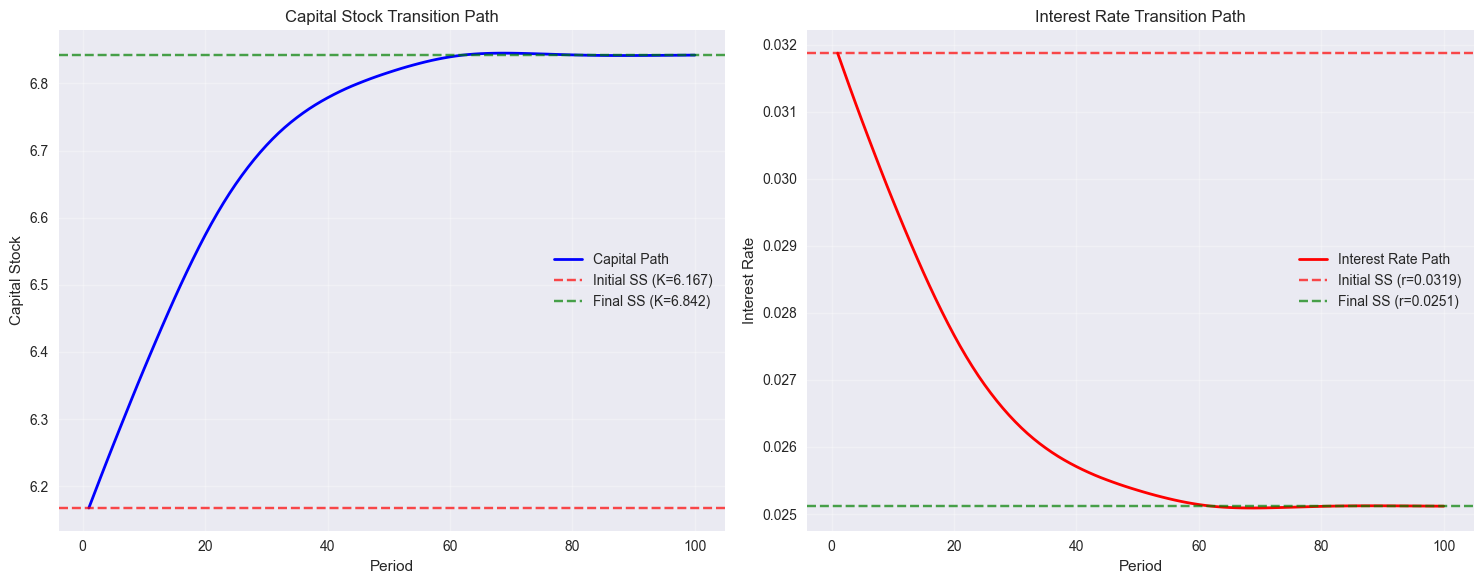

In [18]:
def calculate_factor_prices_path(tr_setting, K_path, initial_setting):
    """移行過程の要素価格を計算"""
    L = initial_setting.Njw / initial_setting.NJ  # 労働供給

    r_path = np.zeros(tr_setting.NT)
    w_path = np.zeros(tr_setting.NT)

    for t in range(tr_setting.NT):
        K_t = K_path[t]
        r_path[t] = (
            initial_setting.alpha * (K_t / L) ** (initial_setting.alpha - 1)
            - initial_setting.delta
        )
        w_path[t] = (1 - initial_setting.alpha) * (K_t / L) ** initial_setting.alpha

    return r_path, w_path


def plot_capital_path(tr_setting, K_path, initial_result, final_result):
    """資本パスと金利パスをプロット"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # 資本パス
    periods = np.arange(1, tr_setting.NT + 1)
    ax1.plot(periods, K_path, "b-", linewidth=2, label="Capital Path")
    ax1.axhline(
        y=initial_result.K,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"Initial SS (K={initial_result.K:.3f})",
    )
    ax1.axhline(
        y=final_result.K,
        color="green",
        linestyle="--",
        alpha=0.7,
        label=f"Final SS (K={final_result.K:.3f})",
    )
    ax1.set_xlabel("Period")
    ax1.set_ylabel("Capital Stock")
    ax1.set_title("Capital Stock Transition Path")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 金利パス
    r_path, _ = calculate_factor_prices_path(tr_setting, K_path, initial_result.hp)
    ax2.plot(periods, r_path, "r-", linewidth=2, label="Interest Rate Path")
    ax2.axhline(
        y=initial_result.r,
        color="red",
        linestyle="--",
        alpha=0.7,
        label=f"Initial SS (r={initial_result.r:.4f})",
    )
    ax2.axhline(
        y=final_result.r,
        color="green",
        linestyle="--",
        alpha=0.7,
        label=f"Final SS (r={final_result.r:.4f})",
    )
    ax2.set_xlabel("Period")
    ax2.set_ylabel("Interest Rate")
    ax2.set_title("Interest Rate Transition Path")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_capital_path(tr_setting, K_path, initial_result, final_result)

# CEV

In [24]:
beta_list = np.empty(initial_result.hp.NJ)
for h in range(initial_result.hp.NJ):
    beta_list[h] = sum(
        [initial_result.hp.beta**H for H in range(initial_result.hp.NJ - h)]
    )

In [25]:
alt_CEV_avg = np.empty((tr_setting.NT, initial_result.hp.NJ, initial_result.hp.Nl))
for t in range(tr_setting.NT):
    for h in range(initial_result.hp.NJ):
        discount = beta_list[h]
        for i_a in range(initial_result.hp.Na):
            for i_l in range(initial_result.hp.Nl):
                if t == 0:
                    # 改革時点の価値関数と比較
                    vf_trans_avg = np.sum(
                        value_functions["V_init"][h, i_l, :] * mu_dists[t, h, i_l, :]
                    ) / np.sum(mu_dists[t, h, i_l, :])
                    vf_init_avg = np.sum(
                        initial_result.value_fun_box[h, i_l, :]
                        * initial_result.mu_dist_box[h, i_l, :]
                    ) / np.sum(initial_result.mu_dist_box[h, i_l, :])
                    alt_CEV_avg[t, h, i_l] = (
                        np.exp((vf_trans_avg - vf_init_avg) / discount) - 1
                    )
                else:
                    vf_trans_avg = np.sum(
                        value_functions["V_start"][t - 1, h, i_l, :]
                        * mu_dists[t, h, i_l, :]
                    ) / np.sum(mu_dists[t, h, i_l, :])
                    vf_init_avg = np.sum(
                        initial_result.value_fun_box[h, i_l, :]
                        * initial_result.mu_dist_box[h, i_l, :]
                    ) / np.sum(initial_result.mu_dist_box[h, i_l, :])
                    alt_CEV_avg[t, h, i_l] = (
                        np.exp((vf_trans_avg - vf_init_avg) / discount) - 1
                    )

/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_41431/2565866220.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "--k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(ages, alt_CEV_avg[period, :, 0], '--k',linewidth=2, label='Low skill (alt CEV)', color="r")
/var/folders/y2/hwl07kg14b31nb5s126cjc8m0000gn/T/ipykernel_41431/2565866220.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-k" (-> color='k'). The keyword argument will take precedence.
  plt.plot(ages, alt_CEV_avg[period, :, 1], '-k', linewidth=2, label='High skill (alt CEV)', color="r")


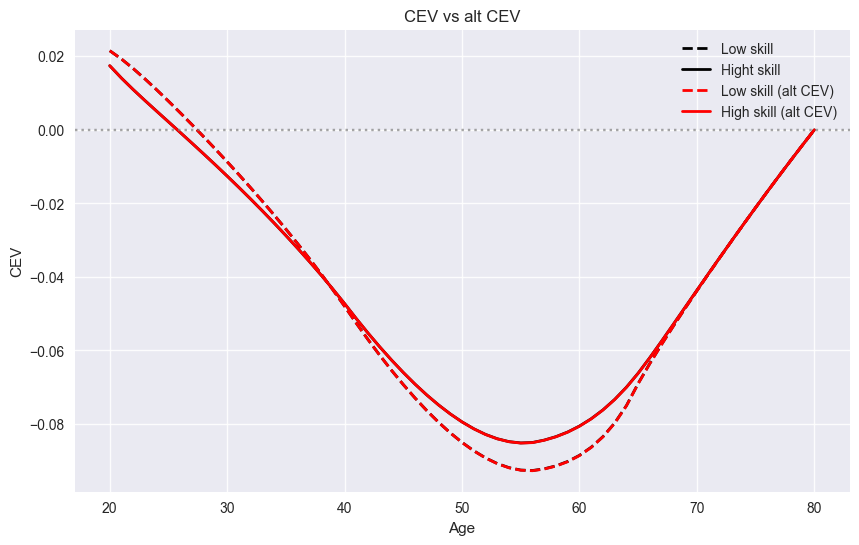

In [26]:
# 第1期(t=0)の年齢別CEV平均をプロット
period = 0
ages = np.arange(20, 20 + initial_result.hp.NJ)
plt.figure(figsize=(10, 6))
plt.plot(ages, CEV_avg[period, :, 0], "--k", linewidth=2, label="Low skill")
plt.plot(ages, CEV_avg[period, :, 1], "-k", linewidth=2, label="Hight skill")
plt.plot(
    ages,
    alt_CEV_avg[period, :, 0],
    "--k",
    linewidth=2,
    label="Low skill (alt CEV)",
    color="r",
)
plt.plot(
    ages,
    alt_CEV_avg[period, :, 1],
    "-k",
    linewidth=2,
    label="High skill (alt CEV)",
    color="r",
)
plt.axhline(y=0, color="gray", linestyle=":", alpha=0.7)
plt.xlabel("Age")
plt.ylabel("CEV")
plt.title("CEV vs alt CEV")
plt.legend()
plt.grid(True, alpha=0.9)
plt.show()

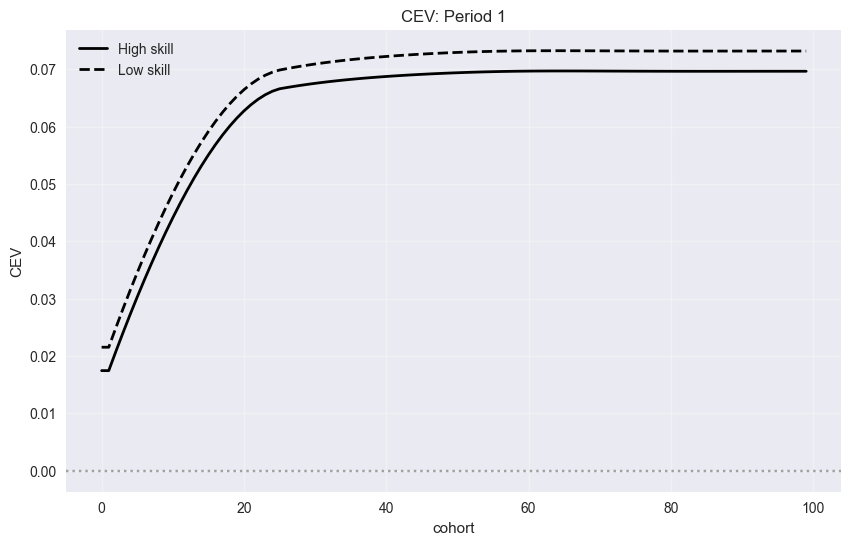

In [27]:
# 第1期(t=0)の年齢別CEV平均をプロット
age = 0
plt.figure(figsize=(10, 6))
plt.plot(CEV_avg[:, age, 1], "-k", linewidth=2, label="High skill")
plt.plot(CEV_avg[:, age, 0], "--k", linewidth=2, label="Low skill")
# plt.plot(ages, CEV_avg[period, :, 1], '-k', linewidth=2, label='High skill')
plt.axhline(y=0, color="gray", linestyle=":", alpha=0.7)
plt.xlabel("cohort")
plt.ylabel("CEV")
plt.title(f"CEV: Period {period + 1}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()